In [13]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

In [14]:
device = "mps"

In [15]:
def reparameterize(mu, logvar):
    std = torch.exp(0.5*logvar)
    eps = torch.randn_like(std)
    return mu + eps*std

In [16]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc_mu = nn.Linear(128 * 16 * 16, 100)  # For mean
        self.fc_logvar = nn.Linear(128 * 16 * 16, 100)  # For log variance

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = self.flatten(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(100, 128 * 16 * 16)
        self.conv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.conv3 = nn.ConvTranspose2d(32, 3, kernel_size=2, stride=2)

    def forward(self, x):
        x = self.fc(x)
        x = F.relu(x)
        x = x.view(-1, 128, 16, 16)  # Reshape to match the encoder's last conv layer output shape
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv3(x))  # Use sigmoid for the last layer if images are normalized between [0,1]
        return x

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

In [17]:
from torch.utils.tensorboard import SummaryWriter
def train(vae, data, epochs=20, initial_lr=0.001, anneal_factor=0.5, anneal_epochs=10):
    opt = torch.optim.Adam(vae.parameters(), lr=initial_lr)
    scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=anneal_epochs, gamma=anneal_factor)
    
    writer = SummaryWriter(log_dir="results/vae_training_2")  # Create a SummaryWriter object for TensorBoard
    
    for epoch in range(epochs):
        losses = 0
        for x in data:
            x = x.to(device)  # Assuming 'device' is defined (e.g., 'cuda' or 'cpu')
            opt.zero_grad()
            x_hat, mu, logvar = vae(x)
            # Reconstruction loss
            recon_loss = F.mse_loss(x_hat, x, reduction='sum')
            # KL divergence
            kld = -1 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            # Total loss
            loss = recon_loss + kld
            losses += loss.item()
            loss.backward()
            opt.step()
        
        scheduler.step()  # Update learning rate
        
        # Write loss and learning rate to TensorBoard
        writer.add_scalar('Reconstruction Loss', recon_loss.item(), epoch)
        writer.add_scalar('KL Divergence', kld.item(), epoch)
        writer.add_scalar('Learning Rate', scheduler.get_lr()[0], epoch)
        
        print(f"Epoch {epoch+1}, Loss: {loss.item()}, Learning Rate: {scheduler.get_lr()[0]}")
    
    writer.close()  # Close the SummaryWriter
    
    return vae

In [18]:
num_epochs = 40
device = "mps"

class BoxingDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.images = [os.path.join(directory, img) for img in os.listdir(directory)]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to a fixed size
    transforms.ToTensor(),        # Convert images to PyTorch tensors
])

dataset = BoxingDataset(directory='images', transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [19]:
autoencoder = VAE().to(device)
autoencoder = train(autoencoder, dataloader, num_epochs)

Epoch 1, Loss: 3071.47021484375, Learning Rate: 0.001
Epoch 2, Loss: 2468.234130859375, Learning Rate: 0.001
Epoch 3, Loss: 2256.4541015625, Learning Rate: 0.001
Epoch 4, Loss: 2405.4287109375, Learning Rate: 0.001
Epoch 5, Loss: 2712.70751953125, Learning Rate: 0.001
Epoch 6, Loss: 1823.59912109375, Learning Rate: 0.001
Epoch 7, Loss: 1800.36083984375, Learning Rate: 0.001
Epoch 8, Loss: 1762.2230224609375, Learning Rate: 0.001
Epoch 9, Loss: 1752.595703125, Learning Rate: 0.001
Epoch 10, Loss: 1698.77099609375, Learning Rate: 0.00025
Epoch 11, Loss: 1583.993896484375, Learning Rate: 0.0005
Epoch 12, Loss: 1623.701171875, Learning Rate: 0.0005
Epoch 13, Loss: 1698.139404296875, Learning Rate: 0.0005
Epoch 14, Loss: 1558.3336181640625, Learning Rate: 0.0005
Epoch 15, Loss: 1539.457763671875, Learning Rate: 0.0005
Epoch 16, Loss: 1691.915283203125, Learning Rate: 0.0005
Epoch 17, Loss: 1470.513916015625, Learning Rate: 0.0005
Epoch 18, Loss: 1451.805908203125, Learning Rate: 0.0005
Epoc

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import random

def imshow(img):
    """
    Helper function to unnormalize and display an image
    """
    img = img / 2 + 0.5  # unnormalize if you used normalization in your transform
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_images(autoencoder, data_set, device):
    """
    Show original and reconstructed images.
    
    Parameters:
    - autoencoder: the trained autoencoder model.
    - data_loader: PyTorch DataLoader containing the dataset.
    - device: PyTorch device to use ('cuda' or 'cpu').
    """
    # Get a batch of images
    image = data_set[random.randint(0, len(data_set))]
    images = image.unsqueeze(0)

    # Move images to the device
    images = images.to(device)

    # Forward pass through the autoencoder
    reconstructed, _, _ = autoencoder(images) # detach to avoid tracking history in autograd
    reconstructed = reconstructed.detach()

    # Move images back to cpu for visualization
    images = images.cpu()
    reconstructed = reconstructed.cpu()

    # Display original images
    print("Original Images")
    imshow(torchvision.utils.make_grid(images))

    # Display reconstructed images
    print("Reconstructed Images")
    imshow(torchvision.utils.make_grid(reconstructed))

Original Images


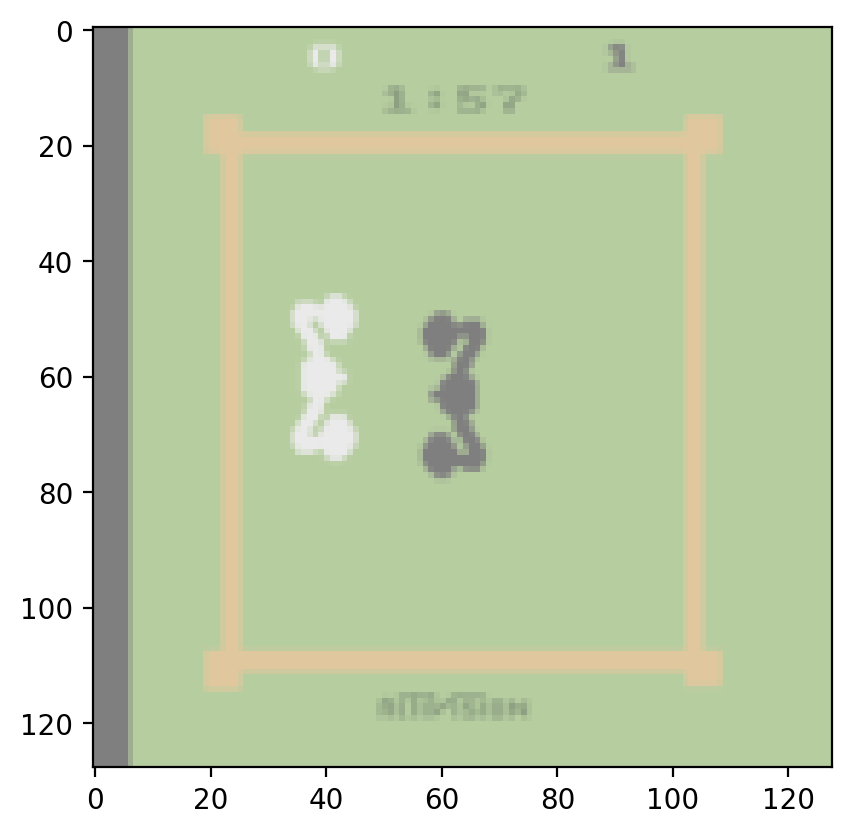

Reconstructed Images


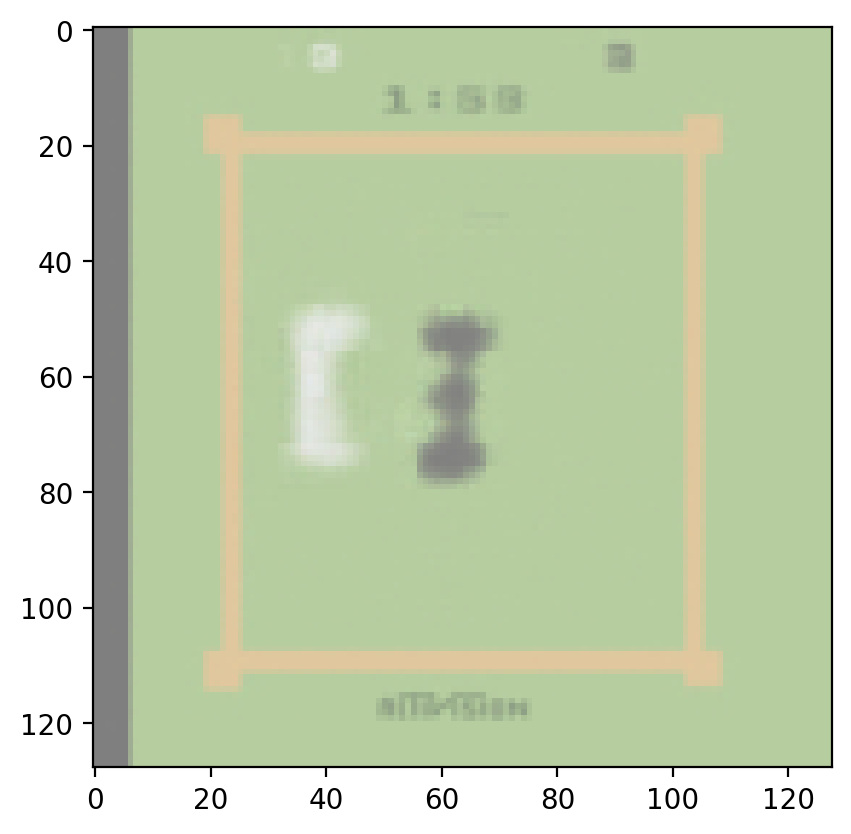

In [27]:
test_dataset = BoxingDataset(directory='images', transform=transform)
test_loader = DataLoader(dataset, batch_size=32, shuffle=True)

show_images(autoencoder, test_dataset, device)

In [22]:
torch.save(autoencoder.state_dict(), "models/vae_100.pth")